# Analysis Report - Xiaoyu Ouyang

In [254]:
# Load packages
import pandas as pd
import numpy as np
import random 
random.seed(0)
import statsmodels.api as sm
pd.set_option('display.float_format',  '{:,.2f}'.format)

## Part 1

In [255]:
# Load the datasets
morg = pd.read_csv("morg96.csv")
house = pd.read_csv("housing_supply.csv")

In [256]:
# Look for columns in morg dataset
morg.columns

Index(['hurespli', 'intmonth', 'minsamp', 'hrsample', 'serial', 'hhnum',
       'state', 'stfips', 'county', 'centcity', 'msafips', 'cmsacode',
       'smsastat', 'smsa93', 'icntcity', 'hhid', 'sex', 'veteran', 'grade92',
       'famnum', 'selfproxy', 'why3594', 'class94', 'unioncov', 'studftpt',
       'relref95', 'age', 'pfamrel', 'marital', 'race', 'hourslw', 'reason94',
       'absent94', 'dwrsn', 'ind80', 'occ80', 'uhourse', 'laydur', 'paidhre',
       'unionmme', 'ethnic', 'lfsr94', 'untype', 'ftpt94', 'agri', 'eligible',
       'otc', 'earnhre', 'earnwke', 'schenr', 'schlvl', 'weight', 'earnwt',
       'I25a', 'I25b', 'I25c', 'I25d', 'penatvty', 'pemntvty', 'pefntvty',
       'prcitshp', 'prcitflg', 'peinusyr', 'hrlonglk', 'lineno', 'recnum',
       'year', 'ym_file', 'ym', 'docc80', 'dind'],
      dtype='object')

## Part 2

In [257]:
# Choose workers ages 25-35 and reported working >=35h last week
morg1 = morg[(morg["age"]>=25) & (morg["age"]<=55) & (morg["hourslw"]>=35)]

# Exclude self-employed workers: class94 = 6 or 7
morg1 = morg1[(morg1["class94"]!=6) & (morg1["class94"]!=7)]

# Check for classes of workers
classes = morg1["class94"].unique()  # array([5., 4., 2., 1., 3., 8.])

It is important to note that a direct mapping from "grade92" to "yrsch" (representing years of schooling) does not exist in the datasets. To handle cases where a value of "grade92" corresponds to multiple possible years of schooling, a random value within the range is assigned to "yrsch". For example, if "grade92" equals 32 (indicating 1-4th grade), a random integer within the range [1, 4] is assigned to "yrsch". This approach is preferred over other methods, such as using the range average, to avoid underestimating the standard deviation of the population.

In [258]:
# Transform variable grade92 to years of schooling (yrsch). 
def grade92_to_yrsch(x):
        '''
    The following text is in the format of "grade/degree" "grade92" --- "value/range of years of schooling" 
            Less than 1st grade 31 --- 0
            1st - 4th grade 32 --- [1,4]
            5th or 6th 33 --- [5,6]
            7th or 8th 34 --- [7,8]
            9th 35 --- 9
            10th 36 ---10
            11th 37 --- 11
            12th grade NO DIPLOMA 38 --- 12
            High school graduate, diploma or GED 39 --- 12
            Some college but no degree 40 --- [13,14]
            Associate degree -- occupational/vocational 41 --- 14
            Associate degree -- academic program 42 --- 14
            Bachelor's degree (e.g. BA,AB,BS) 43 ---16
            Master's degree (e.g. MA,MS,MEng,Med,MSW,MBA) 44 --- [17,18]
            Professional school deg. (e.g. MD,DDS,DVM,LLB,JD) 45 ---19
            Doctorate degree (e.g. PhD, EdD) 46 --- [21,23]
    '''
        if x == 31:
            return 0
        elif x == 32:
            return random.randint(1, 4)
        elif x == 33:
            return random.randint(5, 6)
        elif x == 34:
            return random.randint(7, 8)
        elif x == 35:
            return 9
        elif x == 36:
            return 10
        elif x == 37:
            return 11
        elif x == 38:
            return 12
        elif x == 39:
            return 12
        elif x == 40: 
            return random.randint(13, 14)
        elif x == 41:
            return 14
        elif x == 42:
            return 14
        elif x == 43:
            return 16
        elif x == 44:
            return random.randint(17,18)
        elif x == 45:
            return 19
        elif x == 46:
            return random.randint(21,23)
        else:
            return

In [259]:
# Generate a new column "yrsch" 
morg1["yrsch"] = morg1["grade92"].apply(grade92_to_yrsch)
var_list = ["earnwke", "yrsch", "sex", "age"]

# Create a function of calculating summary statistics
def summary_stats(df):
    summary = df[var_list].describe().T
    ret = summary[["mean", "std", "min", "max"]]
    return ret

In [260]:
# Private sector workers
private = morg1[(morg1["class94"] == 4) | (morg1["class94"] == 5)]
ret1 = summary_stats(private)
ret1.style.set_caption("Summary Statistics Table for Private Sector").format('{:.2f}')

,mean,std,min,max
earnwke,605.71,373.42,0.00,1923.00
yrsch,13.41,2.61,0.00,23.00
sex,1.42,0.49,1.00,2.00
age,38.47,8.32,25.00,55.00


In [261]:
# Local goverment workers
local =  morg1[morg1["class94"] == 3]
ret2 = summary_stats(local)
ret2.style.set_caption("Summary Statistics Table for Local Government").format('{:.2f}')

,mean,std,min,max
earnwke,633.32,330.24,0.00,1923.00
yrsch,14.66,2.43,0.00,23.00
sex,1.54,0.50,1.00,2.00
age,40.85,8.30,25.00,55.00


In [262]:
# State government workers
state = morg1[morg1["class94"] == 2]
ret3 = summary_stats(state)
ret3.style.set_caption("Summary Statistics Table for State Government").format('{:.2f}')

,mean,std,min,max
earnwke,619.84,321.86,0.00,1923.00
yrsch,15.06,2.85,1.00,23.00
sex,1.52,0.50,1.00,2.00
age,40.79,8.16,25.00,55.00


In [263]:
# Federal goverment workers
federal = morg1[morg1["class94"] == 1]
ret4 = summary_stats(federal)
ret4.style.set_caption("Summary Statistics Table for Federal Government").format('{:.2f}')

,mean,std,min,max
earnwke,725.59,349.45,0.00,1923.00
yrsch,14.28,2.27,3.00,23.00
sex,1.43,0.50,1.00,2.00
age,41.55,7.80,25.00,55.00


## Part 3

In [264]:
# Merge CPS-MORG data with housing_supply dataframe based on column "msafips"
morg3 = morg1.merge(house, on = 'msafips', validate = 'm:1')
morg3.head()

,hurespli,intmonth,minsamp,hrsample,serial,hhnum,state,stfips,county,centcity,...,hrlonglk,lineno,recnum,year,ym_file,ym,docc80,dind,yrsch,unaval
0,2,1,8,A64,-1,1,63,1,0,1.00,...,2,2,5,1996,432,416,12.00,45.00,16,0.15
1,1,1,4,A65,-1,1,63,1,0,1.00,...,2,1,34,1996,432,429,2.00,33.00,16,0.15
2,1,1,4,A65,-1,1,63,1,0,1.00,...,2,1,63,1996,432,429,16.00,33.00,13,0.15
3,2,1,4,A65,-1,1,63,1,0,2.00,...,2,1,72,1996,432,429,23.00,4.00,12,0.15
4,1,1,4,A65,-1,1,63,1,0,2.00,...,2,2,116,1996,432,429,34.00,4.00,12,0.15


## Part 4

In [265]:
# Exclude federal goverment or state goverment workers from dataframe morg3
morg4 = morg3[(morg3["class94"] != 2) & (morg3["class94"] != 1)].copy()

# Create a new variable called "logearnwke" for ln(weekly earnings) using rows with positive "earnwke" 
morg4 = morg4[morg4["earnwke"] >0]
log = lambda x: np.log(x)
morg4["logearnwke"] = morg4["earnwke"].apply(log)

# Create a variable called "localgov" for Indicator of whether the worker is employed by local goverment or not 
morg4["localgov"] = [1 if x == 3 else 0 for x in morg4["class94"]]

# Run a regression of logearnwke ~ Indicator(whether employed by the local goverment or not)
Y = morg4["logearnwke"]
X = sm.add_constant(morg4["localgov"])
model = sm.OLS(Y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logearnwke   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     124.7
Date:                Thu, 23 Mar 2023   Prob (F-statistic):           6.43e-29
Time:                        13:27:54   Log-Likelihood:                -47796.
No. Observations:               53436   AIC:                         9.560e+04
Df Residuals:                   53434   BIC:                         9.561e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2756      0.003   2339.262      0.000       6.270       6.281
localgov       0.1003      0.009     11.166      0.000       0.083       0.118
==============================================================================
Omnibus:                     7108.319   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41162.708
Skew:                          -0.506   Prob(JB):                         0.00
Kurtosis:                       7.179   Cond. No.                         3.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [266]:
(np.exp(0.1003)-1)*100

10.55025190887353

The regression analysis indicates that localgov is a statistically significant variable with a negligible p-value. The estimated coefficient of 0.1003 suggests that being employed by the local government is associated with a 10.55% increase in weekly earnings, as compared to those working in the private sector. Therefore, it can be concluded that public sector workers earn more.

## Part 5

To add controls for workers' demographics to the regressions, I include these additional variables in the regression model. 

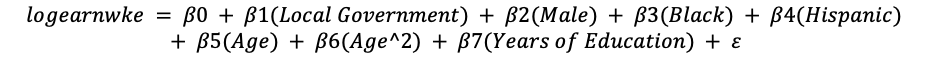

In [267]:
# Create variables for sex, race, hispanic, age, age_squared, years of education
morg4["male"] = [1 if x == 1 else 0 for x in morg4["sex"]]
morg4["black"] = [1 if x == 2 else 0 for x in morg4["race"]]
morg4 = morg4[morg4["ethnic"]!=9].dropna(subset=["ethnic"]) # exclude rows with race unknown or equal to nan values
morg4["hispanic"] =  [0 if x == 8 else 1 for x in morg4["ethnic"]]
morg4["age_squared"] = morg4["age"].apply(lambda x: x**2)

# Run regression 
Y = morg4["logearnwke"]
X = sm.add_constant(morg4[["localgov", "male", "black", "hispanic", "age", "age_squared", "yrsch"]])
model = sm.OLS(Y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logearnwke   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     3289.
Date:                Thu, 23 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:28:11   Log-Likelihood:                -38108.
No. Observations:               53236   AIC:                         7.623e+04
Df Residuals:                   53228   BIC:                         7.630e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.4779      0.049     70.728      0.000       3.381       3.574
localgov        0.0129      0.008      1.684      0.092      -0.002       0.028
male            0.2877      0.004     66.042      0.000       0.279       0.296
black          -0.2085      0.007    -30.679      0.000      -0.222      -0.195
hispanic       -0.1325      0.008    -17.422      0.000      -0.147      -0.118
age             0.0655      0.003     26.197      0.000       0.061       0.070
age_squared    -0.0007   3.17e-05    -22.185      0.000      -0.001      -0.001
yrsch           0.0914      0.001    109.101      0.000       0.090       0.093
==============================================================================
Omnibus:                    15858.277   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           196130.616
Skew:                          -1.082   Prob(JB):                         0.00
Kurtosis:                      12.151   Cond. No.                     3.88e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [268]:
(np.exp(0.0129)-1)*100

1.2983563938328668

Based on the regression results table above, the p-value of "localgov" is not statistically significant at the 5% level, with a value of 0.092. This indicates that there is insufficient evidence to reject the null hypothesis that the coefficient of localgov is equal to zero. However, when additional demographic variables are included in the model, the coefficient of "localgov" decreases from 0.1003 to 0.0129, suggesting that being employed by local goverment is associated with a minimal 1.30% increase in weekly earnings. Therefore, it can be concluded that the wage gap between local government and private sector workers decreases after controlling for demographic factors.

## Part 6

Note that the variable for the amount of land available is not given in the MSA dataset and the definition of the variable "unaval" is ambigouous. Therefore, here we make certain assumptions of the variable "unaval" and "aval" to conduct futher analysis. 

Assume the  "unavailibility" of a metropolitan region is defined as the area of unavailable land for real-estate development divided by the entire area of that region, which is a ratio within range [0,1]. 
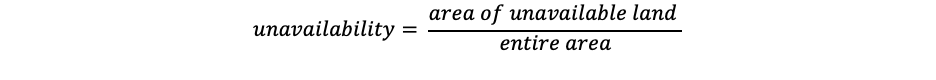
Similarly, "availibility" is defined below and equals to 1-unavailability. 
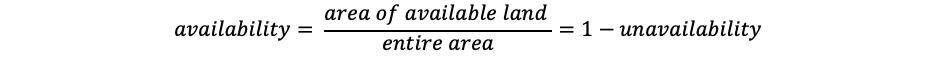
Suppose we have a dataset of size n of unavailability {u_1,u_2,…,u_n  }, then the MSA “unaval” variable (u_i~) for i=1,2,…,n is computed as
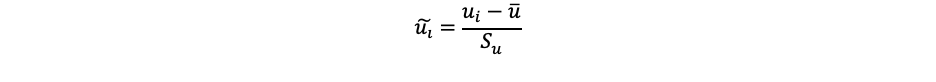 where u ̅ is the mean and S_u is the standard deviation as

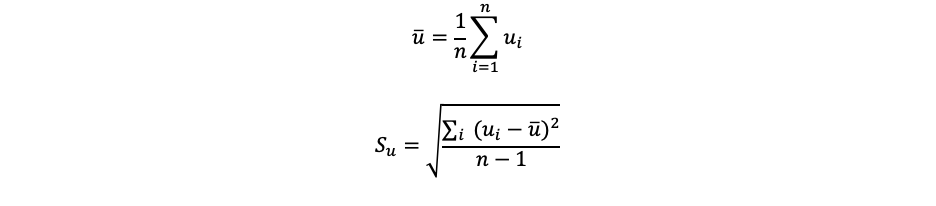
Then to construct a similar “aval” variable  (v_i~ ) for i=1,2,…n, we have
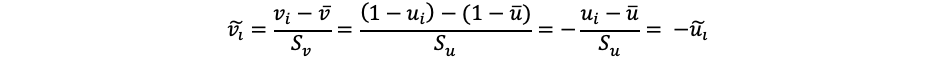
because
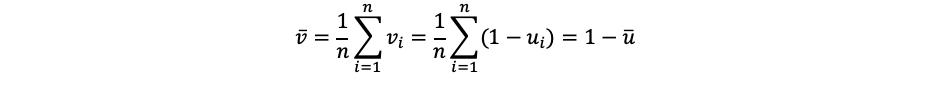
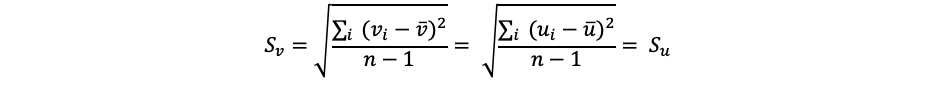

Therefore, we obtain the z-scored measure of land availability ("aval") as the negative of "unaval" variable and add this variable into the dataframe.

In [269]:
# Create variables for availiability, interaction between available land and whether employed by local goverment
morg4["aval"] = -morg4["unaval"]
morg4["interaction"] = morg4.aval * morg4.localgov

# Run regression with clustered standard errors by metropolitan statistical area
"""
Note that using clustered standard errors is necessary here as datapoints from the same metropolitan area are not independent. This correlation violates the regression assumption and brings underestimated standard errors. 
"""
Y = morg4["logearnwke"]
X = sm.add_constant(morg4[["localgov", "male", "black", "hispanic", "age", "age_squared", "yrsch", "aval", "interaction"]])
model = sm.OLS(Y,X).fit(cov_type='cluster', cov_kwds={'groups': morg4['msafips']}, use_t=True) 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logearnwke   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     1100.
Date:                Thu, 23 Mar 2023   Prob (F-statistic):          7.19e-164
Time:                        13:28:57   Log-Likelihood:                -38092.
No. Observations:               53236   AIC:                         7.620e+04
Df Residuals:                   53226   BIC:                         7.629e+04
Df Model:                           9                                         
Covariance Type:              cluster                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.4798      0.057     61.582      0.000       3.368       3.591
localgov        0.0088      0.011      0.803      0.423      -0.013       0.030
male            0.2878      0.009     32.741      0.000       0.270       0.305
black          -0.2085      0.009    -22.106      0.000      -0.227      -0.190
hispanic       -0.1362      0.015     -9.173      0.000      -0.166      -0.107
age             0.0655      0.003     24.026      0.000       0.060       0.071
age_squared    -0.0007   3.43e-05    -20.473      0.000      -0.001      -0.001
yrsch           0.0914      0.002     46.649      0.000       0.088       0.095
aval           -0.0067      0.008     -0.857      0.393      -0.022       0.009
interaction    -0.0294      0.011     -2.600      0.010      -0.052      -0.007
==============================================================================
Omnibus:                    15903.112   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           196807.550
Skew:                          -1.085   Prob(JB):                         0.00
Kurtosis:                      12.166   Cond. No.                     3.88e+04
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 3.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [270]:
(np.exp(0.0088)-1)*100

0.8838833828980208

Based on the regression results table above, the p-value of "localgov" is not statistically significant with a value of 0.423. This indicates that there is insufficient evidence to reject the null hypothesis that the coefficient of localgov is equal to zero. However, when additional variables "aval" and "interaction" are included, the coefficient of localgov decreases further to 0.0088. This suggests that being employed by local goverment is associated with a minimal 0.883% increase in weekly earnings. Therefore, the wage gap between local government and private sector workers further decreases after controlling for availability and interaction between "aval" and "localgov".

## Part 7

Note that there is no such variable that direcly distinguishes workers with at least a 4 year college degree vs those with less education. Here we split two cases according to the variable for years of schooling "yrsch" by following the assumption that workers with at least a 4 year college degree have at least 16 years of schooling.

In [271]:
# Split dataframes according to whether workers have college degrees or not
df = morg4.copy()
edu = df[df["yrsch"] >=16]
lessedu= df[df["yrsch"] < 16]

### Analysis for workers with college degrees

In [272]:
# Run a regression of logearnwke ~ Indicator(whether employed by the local goverment or not)
Y = edu["logearnwke"]
X = sm.add_constant(edu["localgov"])
model = sm.OLS(Y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logearnwke   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.68
Date:                Thu, 23 Mar 2023   Prob (F-statistic):            0.00109
Time:                        13:29:35   Log-Likelihood:                -14166.
No. Observations:               16729   AIC:                         2.834e+04
Df Residuals:                   16727   BIC:                         2.835e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6322      0.005   1409.775      0.000       6.623       6.641
localgov      -0.0411      0.013     -3.268      0.001      -0.066      -0.016
==============================================================================
Omnibus:                     4770.490   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44819.937
Skew:                          -1.099   Prob(JB):                         0.00
Kurtosis:                      10.712   Cond. No.                         2.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [273]:
# Add controls for demographic variables
Y = edu["logearnwke"]
X = sm.add_constant(edu[["localgov", "male", "black", "hispanic", "age", "age_squared", "yrsch"]])
model = sm.OLS(Y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logearnwke   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     403.5
Date:                Thu, 23 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:29:37   Log-Likelihood:                -12865.
No. Observations:               16729   AIC:                         2.575e+04
Df Residuals:                   16721   BIC:                         2.581e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.4581      0.101     34.139      0.000       3.260       3.657
localgov       -0.0226      0.012     -1.882      0.060      -0.046       0.001
male            0.2204      0.008     26.460      0.000       0.204       0.237
black          -0.2058      0.016    -13.212      0.000      -0.236      -0.175
hispanic       -0.1682      0.021     -8.088      0.000      -0.209      -0.127
age             0.0905      0.005     18.873      0.000       0.081       0.100
age_squared    -0.0010   6.11e-05    -16.503      0.000      -0.001      -0.001
yrsch           0.0690      0.003     23.062      0.000       0.063       0.075
==============================================================================
Omnibus:                     6513.530   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            93705.186
Skew:                          -1.475   Prob(JB):                         0.00
Kurtosis:                      14.213   Cond. No.                     4.20e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [274]:
# Add controls for aval and interaction
Y = edu["logearnwke"]
X = sm.add_constant(edu[["localgov", "male", "black", "hispanic", "age", "age_squared", "yrsch", "aval", "interaction"]])
model = sm.OLS(Y,X).fit(cov_type='cluster', cov_kwds={'groups': edu['msafips']}, use_t=True) 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logearnwke   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     217.4
Date:                Thu, 23 Mar 2023   Prob (F-statistic):           1.48e-97
Time:                        13:29:37   Log-Likelihood:                -12858.
No. Observations:               16729   AIC:                         2.574e+04
Df Residuals:                   16719   BIC:                         2.581e+04
Df Model:                           9                                         
Covariance Type:              cluster                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.4623      0.113     30.774      0.000       3.240       3.684
localgov       -0.0260      0.013     -2.041      0.043      -0.051      -0.001
male            0.2204      0.011     19.376      0.000       0.198       0.243
black          -0.2056      0.018    -11.239      0.000      -0.242      -0.170
hispanic       -0.1730      0.036     -4.778      0.000      -0.244      -0.102
age             0.0903      0.005     17.656      0.000       0.080       0.100
age_squared    -0.0010   6.51e-05    -15.470      0.000      -0.001      -0.001
yrsch           0.0689      0.004     17.187      0.000       0.061       0.077
aval           -0.0079      0.010     -0.799      0.425      -0.028       0.012
interaction    -0.0300      0.012     -2.483      0.014      -0.054      -0.006
==============================================================================
Omnibus:                     6529.547   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            94101.133
Skew:                          -1.479   Prob(JB):                         0.00
Kurtosis:                      14.236   Cond. No.                     4.21e+04
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 4.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [276]:
print([np.exp(-0.0411)-1, np.exp(-0.0226)-1, np.exp(-0.0260)-1])

[-0.04026684816621018, -0.022346533041789685, -0.025664910391250628]


Regression Results for workers with 4-year college degress:
-  "localgov" is statistically significant and brings a decrease of 4.02% of weekly earnings when "localgov" is the only explanatory varible. 
- After controlling for demographic variables, "localgov" is statistically significant and brings a smaller decrese of 0.022% to weekly earnings. 
- After further controlling for availiability of land, there is still no evidence supporting that "localgov" is significant and brings a minimal decrese of 0.026% to weekly earnings.

These regressions together show that being employed by local goverment or private sector becomes less significant to weekly earnings of highly educated workers when considering their demogrphic attributes and land availability. Highly educated workers earn more in private sector than in local goverment but the wage difference becomes ignorable by adding more controls. 

# Analysis for workers with less education

In [277]:
# Run a regression of logearnwke ~ Indicator(whether employed by the local goverment or not)
Y = lessedu["logearnwke"]
X = sm.add_constant(lessedu["localgov"])
model = sm.OLS(Y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logearnwke   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     14.67
Date:                Thu, 23 Mar 2023   Prob (F-statistic):           0.000128
Time:                        13:30:17   Log-Likelihood:                -29062.
No. Observations:               36507   AIC:                         5.813e+04
Df Residuals:                   36505   BIC:                         5.814e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1251      0.003   2108.610      0.000       6.119       6.131
localgov       0.0433      0.011      3.831      0.000       0.021       0.066
==============================================================================
Omnibus:                     6225.055   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47277.326
Skew:                          -0.614   Prob(JB):                         0.00
Kurtosis:                       8.438   Cond. No.                         4.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [278]:
# Add controls for demographic variables
Y = lessedu["logearnwke"]
X = sm.add_constant(lessedu[["localgov", "male", "black", "hispanic", "age", "age_squared", "yrsch"]])
model = sm.OLS(Y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logearnwke   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     1366.
Date:                Thu, 23 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:30:19   Log-Likelihood:                -24822.
No. Observations:               36507   AIC:                         4.966e+04
Df Residuals:                   36499   BIC:                         4.973e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.8802      0.059     66.307      0.000       3.766       3.995
localgov        0.0164      0.010      1.615      0.106      -0.003       0.036
male            0.3127      0.005     61.548      0.000       0.303       0.323
black          -0.1992      0.007    -26.893      0.000      -0.214      -0.185
hispanic       -0.1592      0.008    -19.383      0.000      -0.175      -0.143
age             0.0564      0.003     19.460      0.000       0.051       0.062
age_squared    -0.0006   3.66e-05    -16.105      0.000      -0.001      -0.001
yrsch           0.0701      0.001     49.985      0.000       0.067       0.073
==============================================================================
Omnibus:                     9443.473   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110433.042
Skew:                          -0.912   Prob(JB):                         0.00
Kurtosis:                      11.323   Cond. No.                     3.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [279]:
# Add controls for aval and interaction
Y = lessedu["logearnwke"]
X = sm.add_constant(lessedu[["localgov", "male", "black", "hispanic", "age", "age_squared", "yrsch", "aval", "interaction"]])
model = sm.OLS(Y,X).fit(cov_type='cluster', cov_kwds={'groups': lessedu['msafips']}, use_t=True) 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logearnwke   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     643.5
Date:                Thu, 23 Mar 2023   Prob (F-statistic):          2.05e-141
Time:                        13:30:28   Log-Likelihood:                -24813.
No. Observations:               36507   AIC:                         4.965e+04
Df Residuals:                   36497   BIC:                         4.973e+04
Df Model:                           9                                         
Covariance Type:              cluster                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.8817      0.061     64.019      0.000       3.762       4.001
localgov        0.0112      0.015      0.764      0.446      -0.018       0.040
male            0.3128      0.009     33.526      0.000       0.294       0.331
black          -0.1991      0.011    -17.892      0.000      -0.221      -0.177
hispanic       -0.1624      0.014    -11.775      0.000      -0.190      -0.135
age             0.0563      0.003     20.177      0.000       0.051       0.062
age_squared    -0.0006   3.46e-05    -17.026      0.000      -0.001      -0.001
yrsch           0.0701      0.002     31.735      0.000       0.066       0.074
aval           -0.0056      0.007     -0.786      0.433      -0.020       0.008
interaction    -0.0315      0.016     -1.962      0.051      -0.063       0.000
==============================================================================
Omnibus:                     9477.325   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110922.554
Skew:                          -0.916   Prob(JB):                         0.00
Kurtosis:                      11.341   Cond. No.                     3.99e+04
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 3.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [281]:
print([np.exp(0.0433)-1, np.exp(0.0164)-1, np.exp(0.0112)-1])

[0.04425112320097102, 0.01653521818139181, 0.011262954811771086]


Regression Results for workers with less education:
-  "localgov" is statistically significant and brings an increase of 4.43% of weekly earnings when "localgov" is the only explanatory varible. 
- After controlling for demographic variables, "localgov" is statistically significant and brings a smaller decrese of 0.017% to weekly earnings. 
- After further controlling for availiability of land, there is still no evidence supporting that "localgov" is significant and brings a minimal decrese of 0.011% to weekly earnings.

The regressions reveal that the influence of being employed by either the local government or the private sector on the weekly earnings of highly educated workers diminishes as demographic characteristics and land availability are taken into account. In contrast, for less educated workers, working for the local government yields higher wages than the private sector; however, this wage differential becomes negligible upon the inclusion of additional controls.